# DataLab Cup 2: CNN for Object Detection

In [6]:
classes_name =  ["aeroplane", "bicycle", "bird", "boat", "bottle", 
                 "bus", "car", "cat", "chair", "cow", "diningtable", 
                 "dog", "horse", "motorbike", "person", "pottedplant", 
                 "sheep", "sofa", "train","tvmonitor"]

In [107]:
training_data_file = open("./dataset/pascal_voc_training_data.txt", "r")
for i, line in enumerate(training_data_file):
    if i >5:
        break
    line = line.strip()
    print(line)

000005.jpg 263 211 324 339 8 165 264 253 372 8 5 244 67 374 8 241 194 295 299 8 277 186 312 220 8
000007.jpg 141 50 500 330 6
000009.jpg 69 172 270 330 12 150 141 229 284 14 285 201 327 331 14 258 198 297 329 14
000012.jpg 156 97 351 270 6
000016.jpg 92 72 305 473 1
000017.jpg 185 62 279 199 14 90 78 403 336 12


In [12]:
import tensorflow as tf
import numpy as np

from data_aug.data_aug import *
from data_aug.bbox_util import *

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        # for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        # Select GPU number 1
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

2 Physical GPUs, 1 Logical GPUs


## Hyperparameters

In [9]:
# common params
IMAGE_SIZE = 448
BATCH_SIZE = 1
NUM_CLASSES = 20
MAX_OBJECTS_PER_IMAGE = 20

# dataset params
DATA_PATH = './dataset/pascal_voc_training_data.txt'
IMAGE_DIR = './dataset/VOCdevkit_train/VOC2007/JPEGImages/'

# model params
CELL_SIZE = 7
BOXES_PER_CELL = 2
OBJECT_SCALE = 1
NOOBJECT_SCALE = 0.5
CLASS_SCALE = 1
COORD_SCALE = 5

# training params
LEARNING_RATE = 1e-4
EPOCHS = 10

# Data Augmentation

In [4]:
image_names = []
record_list = []
object_num_list = []
# filling the record_list
input_file = open(DATA_PATH, 'r')

for line in input_file:
    line = line.strip()
    ss = line.split(' ')
    image_names.append(ss[0])

    record_list.append([float(num) for num in ss[1:]])

    object_num_list.append(min(len(record_list[-1])//5, MAX_OBJECTS_PER_IMAGE))
    if len(record_list[-1]) < MAX_OBJECTS_PER_IMAGE*5:
        record_list[-1] = record_list[-1] +\
        [0., 0., 0., 0., 0.]*\
        (MAX_OBJECTS_PER_IMAGE-len(record_list[-1])//5)
    elif len(record_list[-1]) > MAX_OBJECTS_PER_IMAGE*5:
        record_list[-1] = record_list[-1][:MAX_OBJECTS_PER_IMAGE*5]
        
# update bounding box 成 配合API的 
# "左上(xmin, ymax), 右下(xmax, ymin)兩點座標 及 label"
def update_bboxes(bbox):

    xmin = bbox[0]
    ymin = bbox[1]
    xmax = bbox[2]
    ymax = bbox[3]
    label = bbox[4]
    
    return [xmin,ymax,xmax,ymin,label]
    
# 判斷object是什麼
# object_class = [[8, 8, 8, 8, 8], [6], ...]
object_class = []
for i in range(len(record_list)):
    object_class2 = []
    k = 4
    for j in range(object_num_list[i]):
        object_class2.append(str(int(record_list[i][k])))
        k += 5
    object_class.append(object_class2)
    

# 得到bounding box
bboxes_list_raw = []
for i in range(len(record_list)):
    count = 0
    bboxes = []
    for j in range(int(len(record_list[i])/5)):
        bboxes.append(record_list[i][count:count + 5])
        count += 5
    
    # [xmin, ymin, xmax, ymax, label] -> [xmin, ymax, xmax, ymin, label]
    bboxes = np.array([update_bboxes(k) for k in bboxes])
    bboxes_list_raw.append(bboxes)

bboxes_list_raw = dict(zip(image_names,bboxes_list_raw))
# bboxes_list_raw

In [5]:
# 判斷是否要 data augmentation
def counter_for_10(object_list):
    # print(object_list) # [8, 8, 8, 8, 8]
    object_strongaug_aug = sum([(i == '10') for i in object_list]) > 0
    object_no_aug = sum([(i == '6' or i == '8' or i == '14') for i in object_list]) > 1
    if object_strongaug_aug and not object_no_aug:
      return  True
    else:
      return False

def counter_for_special(object_list):
    object_strongaug_aug = sum([(i == '1' or i == '10' or i == '12' or i == '13' or i == '5') for i in object_list]) > 0
    object_no_aug = sum([(i == '6' or i == '8' or i == '14') for i in object_list]) > 0
    if object_strongaug_aug and not object_no_aug:
      return  True
    else:
      return False

def counter_element_strong(object_list):
    # 8,6物件(有不需要aug的)
    object_no_aug = sum([(i == '8' or i == '6' or i == '14') for i in object_list]) > 0
    if object_no_aug:
      return False
    else:
      return True

def counter_element(object_list):

    # 非14,非8,非6的物件(需要aug的為0)
    object_need_aug = sum([(i != '14' and  i != '8' and i != '6') for i in object_list]) == 0
    # 14,8,6物件(有不需要aug的)
    object_no_aug = sum([(i == '6' or i == '8' or i == '14') for i in object_list]) > 0
    # 14是否過多
    object_much_14 = sum([i == '14' for i in object_list]) > 0
    # 8是否過多
    #object_much_8 = sum([i == '8' for i in object_list]) > 1
    #object_10 = sum([i == '10' for i in object_list]) < 0

    if (object_need_aug and object_need_aug) or object_much_14:
        return False
    else:
        return True

# aug img name list
aug_names = []

for i in range(int(len(object_class))):
    if counter_for_10(object_class[i]):
        for j in range(20):
            aug_names.append('aug' + "_" + str(j) + "_" + image_names[i])
    elif counter_for_special(object_class[i]) == True:
        for j in range(15):
            aug_names.append('aug' + "_" + str(j) + "_" + image_names[i])
    elif counter_element_strong(object_class[i]) == True:
        for j in range(10):
            aug_names.append('aug' + "_" + str(j) + "_" + image_names[i])
    elif counter_element(object_class[i]) == True:
        for j in range(4):
            aug_names.append('aug' + "_" + str(j) + "_" + image_names[i])
    else:
        aug_names.append("aug" + "_" + '0' + "_" + image_names[i])

In [6]:
# Augmentation parameter

np.random.seed(77)

# HSV
H = np.random.randint(60,size = len(aug_names))
S = np.random.randint(60,size = len(aug_names))
V = np.random.randint(60,size = len(aug_names))

# HorizontalFlip
flip = np.random.binomial(1, 0.5, len(aug_names))

# Scale
scale1 = np.random.uniform(-0.15,0.15,len(aug_names))
scale2 = np.random.uniform(-0.15,0.15,len(aug_names))

# Shear
shear = np.random.uniform(-0.15,0.15,len(aug_names))


random_parameter = dict(zip(aug_names,list(zip(H,S,V,flip,scale1,scale2,shear))))


image_object_dict = dict(zip(image_names,object_num_list))

## Dataset Loader

In [7]:
# class DatasetGenerator:
#     """
#     Load pascalVOC 2007 dataset and creates an input pipeline.
#     - Reshapes images into 448 x 448
#     - converts [0 1] to [-1 1]
#     - shuffles the input
#     - builds batches
#     """

#     def __init__(self):
#         self.image_names = []
#         self.record_list = []
#         self.object_num_list = []
#         # filling the record_list
#         input_file = open(DATA_PATH, 'r')

#         for line in input_file:
#             line = line.strip()
#             ss = line.split(' ')
#             self.image_names.append(ss[0])

#             self.record_list.append([float(num) for num in ss[1:]])

#             self.object_num_list.append(min(len(self.record_list[-1])//5, 
#                                             MAX_OBJECTS_PER_IMAGE))
#             if len(self.record_list[-1]) < MAX_OBJECTS_PER_IMAGE*5:
#                 # if there are objects less than MAX_OBJECTS_PER_IMAGE, pad the list
#                 self.record_list[-1] = self.record_list[-1] +\
#                 [0., 0., 0., 0., 0.]*\
#                 (MAX_OBJECTS_PER_IMAGE-len(self.record_list[-1])//5)
                
#             elif len(self.record_list[-1]) > MAX_OBJECTS_PER_IMAGE*5:
#                # if there are objects more than MAX_OBJECTS_PER_IMAGE, crop the list
#                 self.record_list[-1] = self.record_list[-1][:MAX_OBJECTS_PER_IMAGE*5]

#     def _data_preprocess(self, image_name, raw_labels, object_num):
#         image_file = tf.io.read_file(IMAGE_DIR+image_name)
#         image = tf.io.decode_jpeg(image_file, channels=3)

#         h = tf.shape(image)[0]
#         w = tf.shape(image)[1]

#         width_ratio  = IMAGE_SIZE * 1.0 / tf.cast(w, tf.float32) 
#         height_ratio = IMAGE_SIZE * 1.0 / tf.cast(h, tf.float32) 

#         image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
#         image = (image/255) * 2 - 1

#         raw_labels = tf.cast(tf.reshape(raw_labels, [-1, 5]), tf.float32)

#         xmin = raw_labels[:, 0]
#         ymin = raw_labels[:, 1]
#         xmax = raw_labels[:, 2]
#         ymax = raw_labels[:, 3]
#         class_num = raw_labels[:, 4]

#         xcenter = (xmin + xmax) * 1.0 / 2.0 * width_ratio
#         ycenter = (ymin + ymax) * 1.0 / 2.0 * height_ratio

#         box_w = (xmax - xmin) * width_ratio
#         box_h = (ymax - ymin) * height_ratio

#         labels = tf.stack([xcenter, ycenter, box_w, box_h, class_num], axis=1)

#         return image, labels, tf.cast(object_num, tf.int32)

#     def generate(self):
#         dataset = tf.data.Dataset.from_tensor_slices((self.image_names, 
#                                                       np.array(self.record_list), 
#                                                       np.array(self.object_num_list)))
#         dataset = dataset.shuffle(100000)
#         dataset = dataset.map(self._data_preprocess, 
#                               num_parallel_calls = tf.data.experimental.AUTOTUNE)
#         dataset = dataset.batch(BATCH_SIZE)
#         dataset = dataset.prefetch(buffer_size=200)

#         return dataset

In [8]:
# Balanced 的 data generater
def get_balance_augmentation():
    #count = 0
    for count in range(len(aug_names)):
        aug_name_list = aug_names[count].split('_')
        object_num = image_object_dict.get(aug_name_list[2])

        #若為０則生成原圖
        if aug_name_list[1] == "0":
            path = IMAGE_DIR +''+ aug_name_list[2]
            img_file = tf.io.read_file(path)
            img = tf.io.decode_jpeg(img_file, channels=3)
            bboxes = bboxes_list_raw.get(aug_name_list[2])
            
            count +=1
            
        # 否則生成變化圖
        else:
            parameter = random_parameter.get(aug_names[count])
            path = IMAGE_DIR +''+ aug_name_list[2]
            img_file = tf.io.read_file(path)
            img = tf.io.decode_jpeg(img_file, channels=3)
            
            bboxes = bboxes_list_raw.get(aug_name_list[2])
            seq = Sequence([RandomHSV((parameter[0],parameter[0]), (parameter[1],parameter[1]), (parameter[2],parameter[2])),
                            RandomHorizontalFlip(parameter[3]), Scale(parameter[4],parameter[5]), Shear(parameter[6])])
            img, bboxes = seq(img.numpy().copy(), bboxes.copy())
            
        if bboxes.shape[0] != 20:
            bboxes = np.concatenate([bboxes,np.zeros((20 - bboxes.shape[0] ,5))],axis = 0)
            
            count +=1
            
        # map function
        h = tf.shape(img)[0]
        w = tf.shape(img)[1]
        
        width_rate = IMAGE_SIZE * 1.0 / tf.cast(w, tf.float32) 
        height_rate = IMAGE_SIZE * 1.0 / tf.cast(h, tf.float32) 
        
        image = tf.image.resize(img, size=[IMAGE_SIZE, IMAGE_SIZE])
        # image = (image/255) * 2 - 1
        # image = tf.keras.applications.vgg16.preprocess_input(image) # vgg16的preprocess
        image = tf.keras.applications.densenet.preprocess_input(image) # denseNet121 的preprocess

        
        # raw_labels = tf.cast(tf.reshape(raw_labels, [-1, 5]), tf.float32)
        raw_labels = tf.cast(bboxes, tf.float32)
        
        # 為了不要讓bboxes的數值爆掉，皆對bboxes range做一個修正。
        xmin = raw_labels.numpy()[:, 0]
        xmin[xmin > w.numpy()] = w.numpy()
        
        ymax = raw_labels.numpy()[:, 1]
        ymax[ymax > h.numpy()] = h.numpy()
        
        xmax = raw_labels.numpy()[:, 2]
        xmax[xmax > w.numpy()] = w.numpy()
        
        ymin = raw_labels.numpy()[:, 3]
        ymin[ymin > h.numpy()] = h.numpy()
        
        class_num = raw_labels[:, 4]

        xcenter = (xmin + xmax) * 1.0 / 2.0 * width_rate
        ycenter = (ymin + ymax) * 1.0 / 2.0 * height_rate

        box_w = (xmax - xmin) * width_rate
        box_h = (ymax - ymin) * height_rate
        
        labels = tf.stack([xcenter, ycenter, box_w, box_h, class_num], axis = 1)
        
        # BBOXES做過濾，以免BBOXES超出邊界。
        if ((xcenter.numpy()[:object_num] > 447.5).sum() + (ycenter.numpy()[:object_num] > 447.5).sum()) > 0:
            continue   

        if ((box_w.numpy()[:object_num] < 0.5).sum() + (box_h.numpy()[:object_num] < 0.5).sum()) > 0:
            continue
            
        if np.any((xcenter - box_w/2) < 0):
            continue
        
        if np.any((ycenter - box_h/2) < 0):
            continue
        
        if np.any((xcenter + box_w/2) > 500):
            continue
        
        if np.any((ycenter + box_h/2) > 500):
            continue
    
    
        yield image, labels, tf.cast(object_num,tf.int32)

# Tensorflow dataset
dataset = tf.data.Dataset.from_generator(get_balance_augmentation,
                                         (tf.float32, tf.float32,tf.int32),
                                         (tf.TensorShape([448,448,3]),tf.TensorShape([20,5]),tf.TensorShape([])))
dataset = dataset.shuffle(2000)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=200)

In [9]:
data_generator = get_balance_augmentation()

## Object Detection Model (YOLO)

### Model

In [14]:
from tensorflow import keras
from tensorflow.keras import layers

In [15]:
def conv_leaky_relu(inputs, filters, size, stride):
    x = layers.Conv2D(filters, size, stride, padding="same",
                      kernel_initializer=tf.keras.initializers.TruncatedNormal())(inputs)
    x = layers.LeakyReLU(0.1)(x)

    return x

In [12]:
# img_inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
# x = conv_leaky_relu(img_inputs, 64, 7, 2)
# x = layers.MaxPool2D()(x)
# x = conv_leaky_relu(x, 192, 3, 1)
# x = layers.MaxPool2D()(x)
# x = conv_leaky_relu(x, 128, 1, 1)
# x = conv_leaky_relu(x, 256, 3, 1)
# x = conv_leaky_relu(x, 256, 1, 1)
# x = conv_leaky_relu(x, 512, 3, 1)
# x = layers.MaxPool2D()(x)
# x = conv_leaky_relu(x, 256, 1, 1)
# x = conv_leaky_relu(x, 512, 3, 1)
# x = conv_leaky_relu(x, 256, 1, 1)
# x = conv_leaky_relu(x, 512, 3, 1)
# x = conv_leaky_relu(x, 256, 1, 1)
# x = conv_leaky_relu(x, 512, 3, 1)
# x = conv_leaky_relu(x, 256, 1, 1)
# x = conv_leaky_relu(x, 512, 3, 1)
# x = conv_leaky_relu(x, 512, 1, 1)
# x = conv_leaky_relu(x, 1024, 3, 1)
# x = layers.MaxPool2D()(x)
# x = conv_leaky_relu(x, 512, 1, 1)
# x = conv_leaky_relu(x, 1024, 3, 1)
# x = conv_leaky_relu(x, 512, 1, 1)
# x = conv_leaky_relu(x, 1024, 3, 1)
# x = conv_leaky_relu(x, 1024, 3, 1)
# x = conv_leaky_relu(x, 1024, 3, 2)
# x = conv_leaky_relu(x, 1024, 3, 1)
# x = conv_leaky_relu(x, 1024, 3, 1)
# x = layers.Flatten()(x)
# x = layers.Dense(4096, 
#                  kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)
# x = layers.LeakyReLU(0.1)(x)
# outputs = layers.Dense(1470, 
#                        kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)

# YOLO = keras.Model(inputs=img_inputs, outputs=outputs, name="YOLO")

In [13]:
# YOLO.summary()

In [16]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)

base_model = tf.keras.applications.DenseNet121(input_shape=input_shape, include_top=False, weights='imagenet',classes=20)
base_model.trainable = False

inputs = keras.Input(shape=input_shape)
x = base_model(inputs, training=False)

x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 1)

x = layers.Flatten()(x)
x = layers.Dense(1024)(x)
x = layers.LeakyReLU(0.1)(x)
outputs = layers.Dense(1470)(x)

DenseNet121 = keras.Model(inputs=inputs, outputs=outputs, name="DenseNet121")
DenseNet121.summary()

Model: "DenseNet121"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 448, 448, 3)]     0         
                                                                 
 densenet121 (Functional)    (None, 14, 14, 1024)      7037504   
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 1024)      9438208   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 1024)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 1024)      9438208   
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 1024)      0         
                                                                 
 flatten (Flatten)           (None, 200704)            

### Define loss

In [15]:
# base boxes (for loss calculation)
base_boxes = np.zeros([CELL_SIZE, CELL_SIZE, 4])

# initializtion for each cell
for y in range(CELL_SIZE):
    for x in range(CELL_SIZE):
        base_boxes[y, x, :] = [IMAGE_SIZE / CELL_SIZE * x, 
                               IMAGE_SIZE / CELL_SIZE * y, 0, 0]

base_boxes = np.resize(base_boxes, [CELL_SIZE, CELL_SIZE, 1, 4])
base_boxes = np.tile(base_boxes, [1, 1, BOXES_PER_CELL, 1])

In [16]:
def iou(boxes1, boxes2):
    """calculate ious
    Args:
      boxes1: 4-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 4]  ====> (x_center, y_center, w, h)
      boxes2: 1-D tensor [4] ===> (x_center, y_center, w, h)

    Return:
      iou: 3-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
      ====> iou score for each cell
    """

    #boxes1 : [4(xmin, ymin, xmax, ymax), cell_size, cell_size, boxes_per_cell]
    boxes1 = tf.stack([boxes1[:, :, :, 0] - boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] - boxes1[:, :, :, 3] / 2,
                      boxes1[:, :, :, 0] + boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] + boxes1[:, :, :, 3] / 2])

    #boxes1 : [cell_size, cell_size, boxes_per_cell, 4(xmin, ymin, xmax, ymax)]
    boxes1 = tf.transpose(boxes1, [1, 2, 3, 0])

    boxes2 =  tf.stack([boxes2[0] - boxes2[2] / 2, boxes2[1] - boxes2[3] / 2,
                      boxes2[0] + boxes2[2] / 2, boxes2[1] + boxes2[3] / 2])

    #calculate the left up point of boxes' overlap area
    lu = tf.maximum(boxes1[:, :, :, 0:2], boxes2[0:2])
    #calculate the right down point of boxes overlap area
    rd = tf.minimum(boxes1[:, :, :, 2:], boxes2[2:])

    #intersection
    intersection = rd - lu 

    #the size of the intersection area
    inter_square = intersection[:, :, :, 0] * intersection[:, :, :, 1]

    mask = tf.cast(intersection[:, :, :, 0] > 0, tf.float32) * tf.cast(intersection[:, :, :, 1] > 0, tf.float32)

    #if intersection is negative, then the boxes don't overlap
    inter_square = mask * inter_square

    #calculate the boxs1 square and boxs2 square
    square1 = (boxes1[:, :, :, 2] - boxes1[:, :, :, 0]) * (boxes1[:, :, :, 3] - boxes1[:, :, :, 1])
    square2 = (boxes2[2] - boxes2[0]) * (boxes2[3] - boxes2[1])

    return inter_square/(square1 + square2 - inter_square + 1e-6)

def losses_calculation(predict, label):
    """
    calculate loss
    Args:
      predict: 3-D tensor [cell_size, cell_size, num_classes + 5 * boxes_per_cell]
      label : [1, 5]  (x_center, y_center, w, h, class)
    """
    label = tf.reshape(label, [-1])

    #Step A. calculate objects tensor [CELL_SIZE, CELL_SIZE]
    #turn pixel position into cell position (corner)
    min_x = (label[0] - label[2] / 2) / (IMAGE_SIZE / CELL_SIZE)
    max_x = (label[0] + label[2] / 2) / (IMAGE_SIZE / CELL_SIZE)

    min_y = (label[1] - label[3] / 2) / (IMAGE_SIZE / CELL_SIZE)
    max_y = (label[1] + label[3] / 2) / (IMAGE_SIZE / CELL_SIZE)

    min_x = tf.floor(min_x)
    min_y = tf.floor(min_y)

    max_x = tf.minimum(tf.math.ceil(max_x), CELL_SIZE)
    max_y = tf.minimum(tf.math.ceil(max_y), CELL_SIZE)
    
    #calculate mask of object with cells
    onset = tf.cast(tf.stack([max_y - min_y, max_x - min_x]), dtype=tf.int32)
    object_mask = tf.ones(onset, tf.float32)

    offset = tf.cast(tf.stack([min_y, CELL_SIZE - max_y, min_x, CELL_SIZE - max_x]), tf.int32)
    offset = tf.reshape(offset, (2, 2))
    object_mask = tf.pad(object_mask, offset, "CONSTANT")

    #Step B. calculate the coordination of object center and the corresponding mask
    #turn pixel position into cell position (center)
    center_x = label[0] / (IMAGE_SIZE / CELL_SIZE)
    center_x = tf.floor(center_x)

    center_y = label[1] / (IMAGE_SIZE / CELL_SIZE)
    center_y = tf.floor(center_y)

    response = tf.ones([1, 1], tf.float32)

    #calculate the coordination of object center with cells
    objects_center_coord = tf.cast(tf.stack([center_y, CELL_SIZE - center_y - 1, 
                             center_x, CELL_SIZE - center_x - 1]), 
                             tf.int32)
    objects_center_coord = tf.reshape(objects_center_coord, (2, 2))

    #make mask
    response = tf.pad(response, objects_center_coord, "CONSTANT")

    #Step C. calculate iou_predict_truth [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    predict_boxes = predict[:, :, NUM_CLASSES + BOXES_PER_CELL:]

    predict_boxes = tf.reshape(predict_boxes, [CELL_SIZE, 
                                               CELL_SIZE, 
                                               BOXES_PER_CELL, 4])
    #cell position to pixel position
    predict_boxes = predict_boxes * [IMAGE_SIZE / CELL_SIZE, 
                                     IMAGE_SIZE / CELL_SIZE, 
                                     IMAGE_SIZE, IMAGE_SIZE]

    #if there's no predict_box in that cell, then the base_boxes will be calcuated with label and got iou equals 0
    predict_boxes = base_boxes + predict_boxes

    iou_predict_truth = iou(predict_boxes, label[0:4])

    #calculate C tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    C = iou_predict_truth * tf.reshape(response, [CELL_SIZE, CELL_SIZE, 1])

    #calculate I tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    I = iou_predict_truth * tf.reshape(response, [CELL_SIZE, CELL_SIZE, 1])

    max_I = tf.reduce_max(I, 2, keepdims=True)

    #replace large iou scores with response (object center) value
    I = tf.cast((I >= max_I), tf.float32) * tf.reshape(response, (CELL_SIZE, CELL_SIZE, 1))

    #calculate no_I tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    no_I = tf.ones_like(I, dtype=tf.float32) - I

    p_C = predict[:, :, NUM_CLASSES:NUM_CLASSES + BOXES_PER_CELL]

    #calculate truth x, y, sqrt_w, sqrt_h 0-D
    x = label[0]
    y = label[1]

    sqrt_w = tf.sqrt(tf.abs(label[2]))
    sqrt_h = tf.sqrt(tf.abs(label[3]))

    #calculate predict p_x, p_y, p_sqrt_w, p_sqrt_h 3-D [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    p_x = predict_boxes[:, :, :, 0]
    p_y = predict_boxes[:, :, :, 1]

    p_sqrt_w = tf.sqrt(tf.minimum(IMAGE_SIZE * 1.0, tf.maximum(0.0, predict_boxes[:, :, :, 2])))
    p_sqrt_h = tf.sqrt(tf.minimum(IMAGE_SIZE * 1.0, tf.maximum(0.0, predict_boxes[:, :, :, 3])))

    #calculate ground truth p 1-D tensor [NUM_CLASSES]
    P = tf.one_hot(tf.cast(label[4], tf.int32), NUM_CLASSES, dtype=tf.float32)

    #calculate predicted p_P 3-D tensor [CELL_SIZE, CELL_SIZE, NUM_CLASSES]
    p_P = predict[:, :, 0:NUM_CLASSES]

    #class_loss
    class_loss = tf.nn.l2_loss(tf.reshape(object_mask, (CELL_SIZE, CELL_SIZE, 1)) * (p_P - P)) * CLASS_SCALE

    #object_loss
    object_loss = tf.nn.l2_loss(I * (p_C - C)) * OBJECT_SCALE

    #noobject_loss
    noobject_loss = tf.nn.l2_loss(no_I * (p_C)) * NOOBJECT_SCALE

    #coord_loss
    coord_loss = (tf.nn.l2_loss(I * (p_x - x)/(IMAGE_SIZE/CELL_SIZE)) +
                  tf.nn.l2_loss(I * (p_y - y)/(IMAGE_SIZE/CELL_SIZE)) +
                  tf.nn.l2_loss(I * (p_sqrt_w - sqrt_w))/IMAGE_SIZE +
                  tf.nn.l2_loss(I * (p_sqrt_h - sqrt_h))/IMAGE_SIZE) * COORD_SCALE

    return class_loss + object_loss + noobject_loss + coord_loss

In [17]:
def yolo_loss(predicts, labels, objects_num):
    """
    Add Loss to all the trainable variables
    Args:
        predicts: 4-D tensor [batch_size, cell_size, cell_size, num_classes + 5 * boxes_per_cell]
        ===> (num_classes, boxes_per_cell, 4 * boxes_per_cell)
        labels  : 3-D tensor of [batch_size, max_objects, 5]
        objects_num: 1-D tensor [batch_size]
    """

    loss = 0.
    
    #you can parallel the code with tf.map_fn or tf.vectorized_map (big performance gain!)
    for i in tf.range(BATCH_SIZE):
        predict = predicts[i, :, :, :]
        label = labels[i, :, :]
        object_num = objects_num[i]

        for j in tf.range(object_num):
            results = losses_calculation(predict, label[j:j+1, :])
            loss = loss + results

    return loss/BATCH_SIZE

### Start training

In [18]:
# dataset = DatasetGenerator().generate()

In [19]:
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
train_loss_metric = tf.keras.metrics.Mean(name='loss')

In [20]:
ckpt = tf.train.Checkpoint(epoch=tf.Variable(0), net=resnet101v2)

manager = tf.train.CheckpointManager(ckpt, './ckpts/YOLO', max_to_keep=3,
                                     checkpoint_name='yolo')

In [21]:
@tf.function
def train_step(image, labels, objects_num):
    with tf.GradientTape() as tape:
        outputs = resnet101v2(image)
        class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
        conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
        class_probs = tf.reshape(outputs[:, 0:class_end], (-1, 7, 7, 20))
        confs = tf.reshape(outputs[:, class_end:conf_end], (-1, 7, 7, 2))
        boxes = tf.reshape(outputs[:, conf_end:], (-1, 7, 7, 2*4))
        predicts = tf.concat([class_probs, confs, boxes], 3)

        loss = yolo_loss(predicts, labels, objects_num)
        train_loss_metric(loss)

    grads = tape.gradient(loss, resnet101v2.trainable_weights)
    optimizer.apply_gradients(zip(grads, resnet101v2.trainable_weights))

In [22]:
from datetime import datetime

In [23]:
print("{}, start training.".format(datetime.now()))
for i in range(EPOCHS):
    train_loss_metric.reset_states()
    ckpt.epoch.assign_add(1)

    for idx, (image, labels, objects_num) in enumerate(dataset):
        train_step(image, labels, objects_num)

    print("{}, Epoch {}: loss {:.2f}".format(datetime.now(), i+1, train_loss_metric.result()))

    save_path = manager.save()
    print("Saved checkpoint for epoch {}: {}".format(int(ckpt.epoch), save_path))

2021-11-24 23:38:07.151609, start training.


/home/gary/DL_course/Deep-Learning-Course-Team-Project/Competition 2/data_aug/bbox_util.py:83: RuntimeWarning: invalid value encountered in true_divide
  delta_area = ((ar_ - bbox_area(bbox))/ar_)


### Predict test data

In [33]:
def process_outputs(outputs):
    """
    Process YOLO outputs into bou
    """

    class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
    conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
    class_probs = np.reshape(outputs[:, 0:class_end], (-1, 7, 7, 20))
    confs = np.reshape(outputs[:, class_end:conf_end], (-1, 7, 7, 2))
    boxes = np.reshape(outputs[:, conf_end:], (-1, 7, 7, 2*4))
    predicts = np.concatenate([class_probs, confs, boxes], 3)

    p_classes = predicts[0, :, :, 0:20]
    C = predicts[0, :, :, 20:22]
    coordinate = predicts[0, :, :, 22:]

    p_classes = np.reshape(p_classes, (CELL_SIZE, CELL_SIZE, 1, 20))
    C = np.reshape(C, (CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 1))

    P = C * p_classes
    #P's shape [7, 7, 2, 20]

    #choose the most confidence one
    # -------------modify-------------
    xmin = []
    ymin = []
    xmax = []
    ymax = []
    class_num = []
    max_conf = []
    max_conf.append(np.max(P))
    index = np.argmax(P)
    index = np.unravel_index(index, P.shape)
    # print(max_conf, P[index]) max_conf == P[index]

    # class_num.append(index[3])

    # coordinate = np.reshape(coordinate, 
    #                         (CELL_SIZE, 
    #                          CELL_SIZE,
    #                          BOXES_PER_CELL, 
    #                          4))

    # max_coordinate = coordinate[index[0], index[1], index[2], :]

    # xcenter = max_coordinate[0]
    # ycenter = max_coordinate[1]
    # w = max_coordinate[2]
    # h = max_coordinate[3]

    # xcenter = (index[1] + xcenter) * (IMAGE_SIZE/float(CELL_SIZE))
    # ycenter = (index[0] + ycenter) * (IMAGE_SIZE/float(CELL_SIZE))

    # w = w * IMAGE_SIZE
    # h = h * IMAGE_SIZE

    # xmin.append(xcenter - w/2.0)
    # ymin.append(ycenter - h/2.0)

    # xmax.append(xmin[0] + w)
    # ymax.append(ymin[0] + h)


    threshold = P[index] * 0.85

    # box_per_grid = 0
    num_of_pred_box = 0
    for i in range(1570):
        idx = np.unravel_index(i, P.shape)
        if(P[idx] > threshold):
            # box_per_grid += 1
            max_conf.append(P[idx])
            class_num.append(idx[3])

            coordinate = np.reshape(coordinate, 
                                    (CELL_SIZE, 
                                    CELL_SIZE,
                                    BOXES_PER_CELL, 
                                    4))

            max_coordinate = coordinate[idx[0], idx[1], idx[2], :]

            xcenter = max_coordinate[0]
            ycenter = max_coordinate[1]
            w = max_coordinate[2]
            h = max_coordinate[3]

            xcenter = (idx[1] + xcenter) * (IMAGE_SIZE/float(CELL_SIZE))
            ycenter = (idx[0] + ycenter) * (IMAGE_SIZE/float(CELL_SIZE))

            w = w * IMAGE_SIZE
            h = h * IMAGE_SIZE

            xmin.append(xcenter - w/2.0)
            ymin.append(ycenter - h/2.0)

            xmax.append(xmin[num_of_pred_box] + w)
            ymax.append(ymin[num_of_pred_box] + h)
            num_of_pred_box += 1
    # print(box_per_grid)

    return xmin, ymin, xmax, ymax, class_num, max_conf, num_of_pred_box # -------------modify-------------

In [29]:
test_img_files = open('./pascal_voc_testing_data.txt')
test_img_dir = './VOCdevkit_test/VOC2007/JPEGImages/'
test_images = []

for line in test_img_files:
    line = line.strip()
    ss = line.split(' ')
    test_images.append(ss[0])

test_dataset = tf.data.Dataset.from_tensor_slices(test_images)

def load_img_data(image_name):
    image_file = tf.io.read_file(test_img_dir+image_name)
    image = tf.image.decode_jpeg(image_file, channels=3)

    h = tf.shape(image)[0]
    w = tf.shape(image)[1]

    image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
    image = (image/255) * 2 - 1

    return image_name, image, h, w

test_dataset = test_dataset.map(load_img_data, num_parallel_calls = tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(32)

In [18]:
ckpt = tf.train.Checkpoint(net=DenseNet121)
ckpt.restore('./densenet121_aug_preprocess-3')

In [31]:
@tf.function
def prediction_step(img):
    return DenseNet121(img, training=False)

### Make prediction and output to txt file

In [34]:
output_file = open('./test_prediction.txt', 'w')

for img_name, test_img, img_h, img_w in test_dataset:
    batch_num = img_name.shape[0]
    for i in range(batch_num):
        # -------------modify-------------
        xmin, ymin, xmax, ymax, class_num, conf, num_of_pred_box = process_outputs(prediction_step(test_img[i:i+1]))
        for j in range(num_of_pred_box):
            xmin[j], ymin[j], xmax[j], ymax[j] = xmin[j]*(img_w[i:i+1]/IMAGE_SIZE), ymin[j]*(img_h[i:i+1]/IMAGE_SIZE), xmax[j]*(img_w[i:i+1]/IMAGE_SIZE), ymax[j]*(img_h[i:i+1]/IMAGE_SIZE)
            #img filename, xmin, ymin, xmax, ymax, class, confidence
            output_file.write(img_name[i:i+1].numpy()[0].decode('ascii')+" %d %d %d %d %d %f\n" %(xmin[j], ymin[j], xmax[j], ymax[j], class_num[j], conf[j]))
        # -------------modify-------------

output_file.close()

### Run evaluation metric

In [35]:
import sys
sys.path.insert(0, './evaluate')

In [36]:
import evaluate
#evaluate.evaluate("input prediction file name", "desire output csv file name")
evaluate.evaluate('./test_prediction.txt', './output_file.csv')

End Evalutation
Ahhhhhhhhhhhhhhhhhh


([<evaluate.BoundingBoxes at 0x17b422a1a08>,
  <evaluate.BoundingBoxes at 0x17b449e7b48>])

## Visualization

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2

In [38]:
all_boudingBoxes, big_boundingBoxes = evaluate.evaluate('./test_prediction.txt', './output_file.csv')

End Evalutation
Ahhhhhhhhhhhhhhhhhh


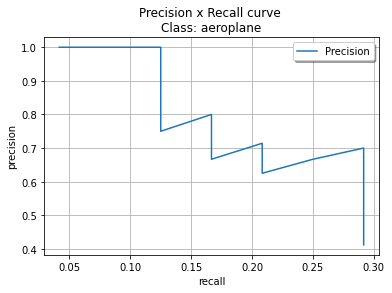

Average Precision:  0.2464285714285714


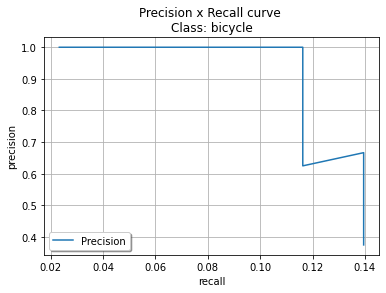

Average Precision:  0.13178294573643412


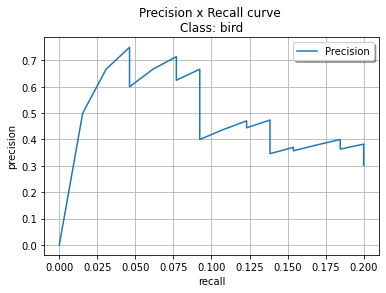

Average Precision:  0.1130560564306694


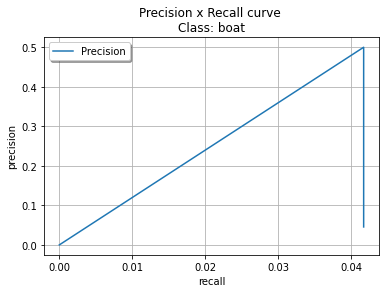

Average Precision:  0.020833333333333332


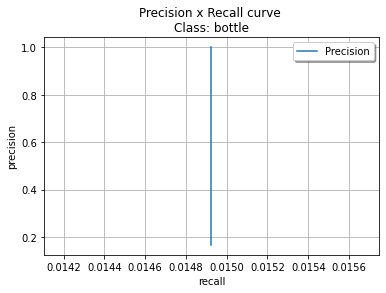

Average Precision:  0.014925373134328358


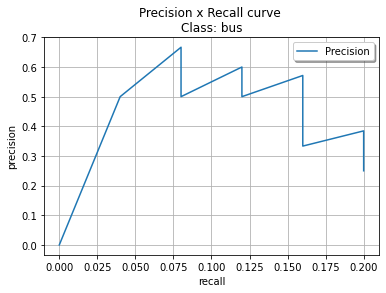

Average Precision:  0.11557509157509158


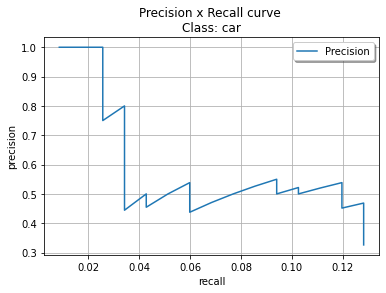

Average Precision:  0.08319773175542405


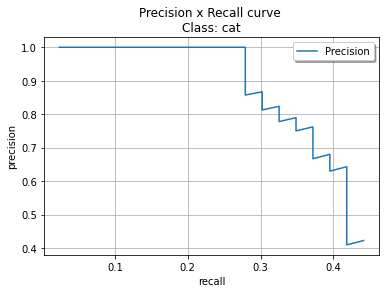

Average Precision:  0.39503846254944247


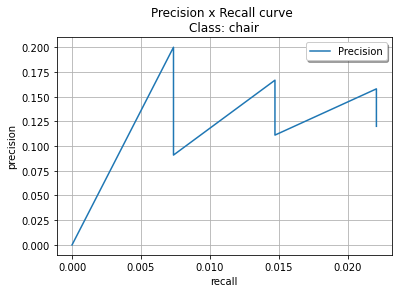

Average Precision:  0.0038570691434468528


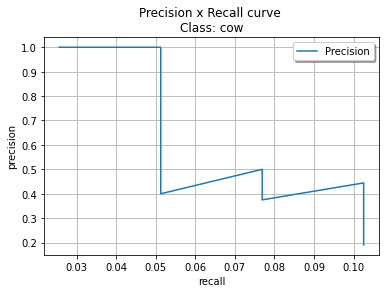

Average Precision:  0.07549857549857548


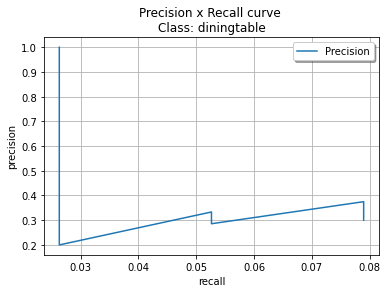

Average Precision:  0.04605263157894737


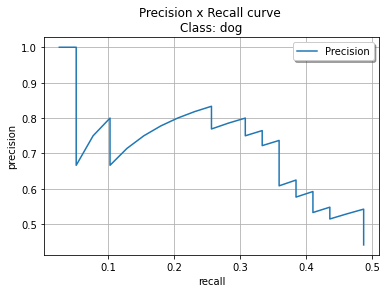

Average Precision:  0.3748694520349702


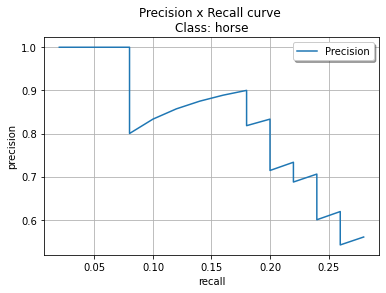

Average Precision:  0.23903193277310925


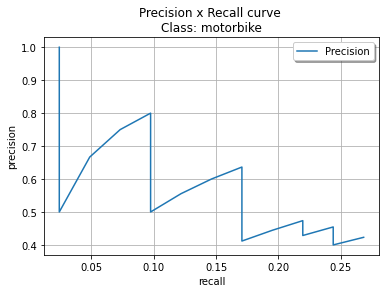

Average Precision:  0.1740019928723395


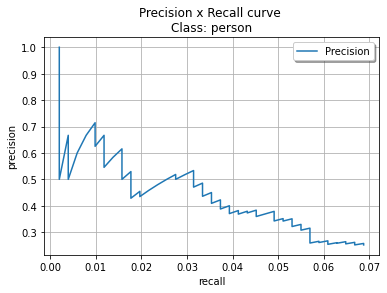

Average Precision:  0.032641967988416974


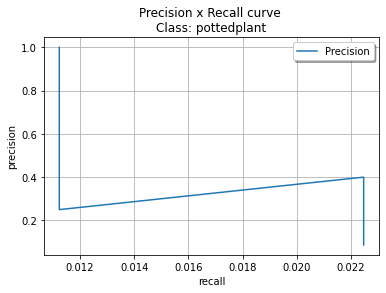

Average Precision:  0.015730337078651686


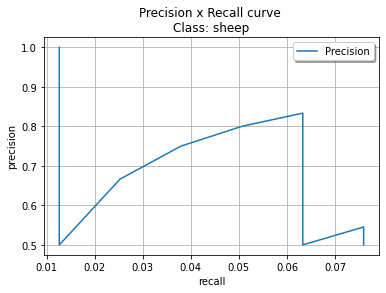

Average Precision:  0.06175680859225163


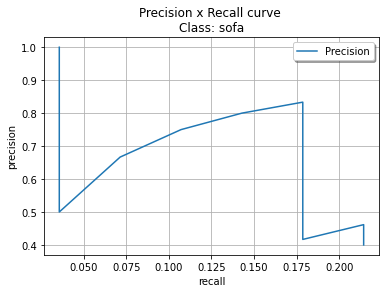

Average Precision:  0.17124542124542125


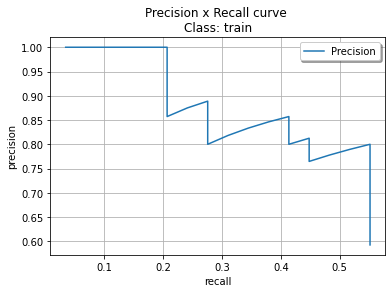

Average Precision:  0.4972016967706622


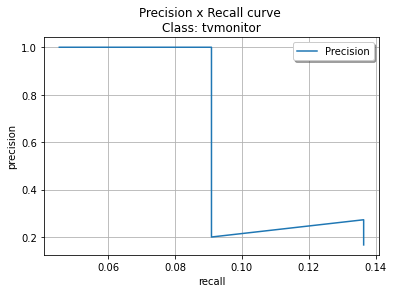

Average Precision:  0.10330578512396695


In [39]:
# ["aeroplane", "bicycle", "bird", "boat", "bottle", 
#     "bus", "car", "cat", "chair", "cow", "diningtable", 
#     "dog", "horse", "motorbike", "person", "pottedplant", 
#     "sheep", "sofa", "train","tvmonitor"]

evaluator = evaluate.Evaluator()

for i in classes_name:
    ret = evaluator.PlotPrecisionRecallCurve(i, all_boudingBoxes[8])
    print('Average Precision: ', ret['AP'])

bird


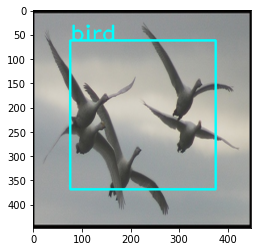

In [45]:
np_img = cv2.imread('./VOCdevkit_test/VOC2007/JPEGImages/000852.jpg')
resized_img = cv2.resize(np_img, (IMAGE_SIZE, IMAGE_SIZE))
np_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
resized_img = np_img
np_img = np_img.astype(np.float32)
np_img = np_img / 255.0 * 2 - 1
np_img = np.reshape(np_img, (1, IMAGE_SIZE, IMAGE_SIZE, 3))

y_pred = DenseNet121(np_img, training=False)
# -------------modify-------------
xmin, ymin, xmax, ymax, class_num, conf, num_of_pred_box = process_outputs(y_pred)
for i in range(num_of_pred_box):
    class_name = classes_name[class_num[i]]
    cv2.rectangle(resized_img, (int(xmin[i]), int(ymin[i])), (int(xmax[i]), int(ymax[i])), (0, 255, 255), 3)
    cv2.putText(resized_img, class_name, (int(xmin[i]), int(ymin[i])), 2, 1.5, (0, 255, 255), 2)
    print(class_name)
    # plt.imshow(resized_img)
    # plt.show()
# -------------modify-------------

plt.imshow(resized_img)
plt.show()